<a href="https://colab.research.google.com/github/rajsegar/Federated-Learning-Frameworks-/blob/main/Spam_Mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Email Analysis using LLMs

## Introduction

This Jupyter notebook demonstrates how to use Large Language Models (LLMs) to analyze emails for potential phishing attempts. We'll use the Ollama framework to run a local LLM, then create a simple GUI for one-shot email analysis. Finally, we will test our process with a realworld datasets of phishing emails.

## Setup

Before we begin let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/phishing-email-dataset


# Step 1: Import Required Libraries
let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.




In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')



import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Load the Dataset
 use a dataset containing labeled emails (Spam or Ham). Let’s load the dataset and inspect its structure.

In [3]:
df = pd.read_csv('/kaggle/input/phishing-email-dataset/SpamAssasin.csv')
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5809 non-null   object
 1   receiver  5599 non-null   object
 2   date      5809 non-null   object
 3   subject   5793 non-null   object
 4   body      5808 non-null   object
 5   label     5809 non-null   int64 
 6   urls      5809 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 317.8+ KB


,0
sender,0
receiver,210
date,0
subject,16
body,1
label,0
urls,0


# Setp 3 : Understand the functionality in mail_check model

In [4]:
df.info()
df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5809 non-null   object
 1   receiver  5599 non-null   object
 2   date      5809 non-null   object
 3   subject   5793 non-null   object
 4   body      5808 non-null   object
 5   label     5809 non-null   int64 
 6   urls      5809 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 317.8+ KB


,count
label,
0,4091
1,1718


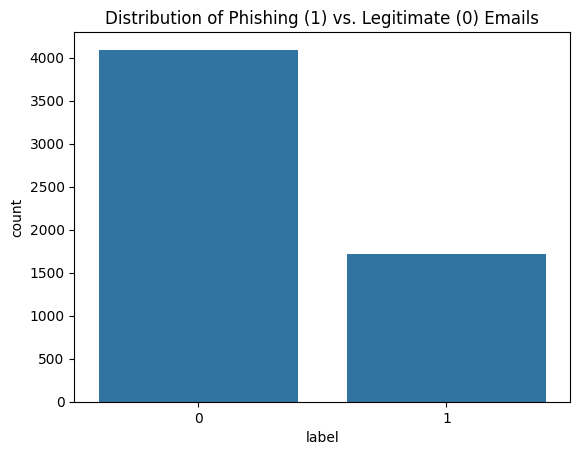

In [5]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [6]:
df['text'] = df['subject'].str.replace('Subject', '')
df.head()

,sender,receiver,date,subject,body,label,urls,text
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1,Re: New Sequences Window
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1,[zzzzteana] RE: Alexander
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1,[zzzzteana] Moscow bomber
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1,[IRR] Klez: The Virus That Won't Die
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1,Re: [zzzzteana] Nothing like mama used to make


In [7]:
# Analyzing the date column
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce', utc=True)
print(df['date'].dtype)

datetime64[ns, UTC]


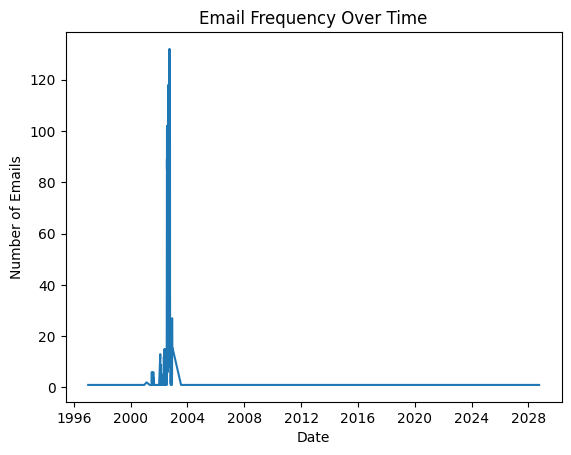

In [8]:
# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

# Handling any remaining NaT values (if any)
df = df.dropna(subset=['date'])

# Plotting the distribution of emails over time
df['Date'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

# Step 4: Determine Accuracy

Accuracy: 0.9399844115354637
Confusion Matrix:
[[596  64]
 [ 13 610]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       660
         1.0       0.91      0.98      0.94       623

    accuracy                           0.94      1283
   macro avg       0.94      0.94      0.94      1283
weighted avg       0.94      0.94      0.94      1283



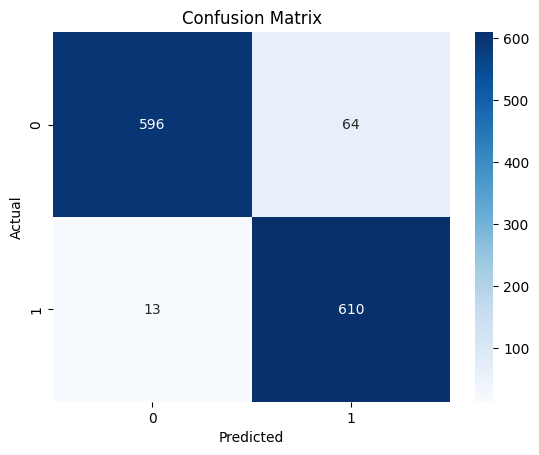

In [15]:
# Preprocessing the body text

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Replace NaNs with empty strings
df['body'] = df['body'].fillna('')

# Now vectorize safely
X_tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Combining other features with TF-IDF features
features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
features['urls'] = df['urls']
features['label'] = df['label']

# Ensure there are no missing values in the features
features = features.dropna()

# Splitting the dataset into features and target
X = features.drop('label', axis=1)
y = features['label']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Building a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/phishing-email-dataset/SpamAssasin.csv')

# Assuming 'model' is a trained RandomForestClassifier
importances = df.feature_importances_
feature_names = X.columns

# Plot
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'feature_importances_'